# Bone Mineral Density
Relative spinal bone mineral density measurements on 261 North American adolescents.  The response is relative change in spinal BMD (the difference in spnbmd taken on two consecutive visits, divided by the average), typically about one year apart. The age is the average age over the two visits.

Variables:

|        |                                                       |
|--------|-------------------------------------------------------|
|idnum   |identifies the child, and hence the repeat measurements|
|age     |average age of child when measurements were taken      |
|gender  |male or female                                         |
|spnbmd  |Relative Spinal bone mineral density measurement       |

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

# set common plots properties
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
# define commonly used colors
RED, BLUE, GRAY4 = '#FF5865', '#0000FF', '#646369'

## Load and Prepare Data

In [2]:
df = pd.read_csv("../data/Bone Mineral Density.txt", sep='\t')
df_male = df[df.gender == 'male']
df_female = df[df.gender == 'female']
df.head()

,idnum,age,gender,spnbmd
0,1,11.70,male,0.018081
1,1,12.70,male,0.060109
2,1,13.75,male,0.005858
3,2,13.25,male,0.010264
4,2,14.30,male,0.210526


## Smoothing Splines
Unfortunately, I did not find any Python library for smoothing splines of a similar implementation from the book. Let's implement it ourselves. First, let's recall the formulas from the book.

**PAGE 145.** A natural cubic spline with $K$ knots is represented by $K$ basis functions. One can start from a basis for cubic splines, and derive the reduced basis by imposing the boundary constraints. For example, starting from the truncated power series basis described in Section 5.2, we arrive at (Excercise 5.4):
$$N_1(X)=1, N_2(X)=X, N_{k+2}(X)=d_{k}(X)-d_{K-1}(X)$$
where $$d_{k}(X)=\frac{(X-\xi_{k})_{+}^{3}-(X-\xi_{K})_{+}^{3}}{\xi_{K}-\xi_{k}}$$

**PAGE 151.** Here we discuss a spline basis method that avoids the knot selection problem completely by using a maximal set of knots. The complexity of the fit is controlled by regularization. Consider the following problem: among all functions $f(x)$ with two continuous derivatives, find one that minimizes the penalized residual sum of squares
$$\operatorname{RSS}(f, \lambda)=\sum_{i=1}^{N}\left\{y_{i}-f\left(x_{i}\right)\right\}^{2}+\lambda \int\left\{f^{\prime \prime}(t)\right\}^{2} d t$$
where $\lambda$ is a fixed *smoothing parameter*. The first term measures closeness to the data, while the second term penalizes curvature in the function, and $\lambda$ establishes a tradeoff between the two.

**PAGE 151.** Since the solution is a natural spline, we can write it as
$$f(x)=\sum_{j=1}^{N} N_{j}(x) \theta_{j}$$
where the $N_j(x)$ are a N-dimensional set of basis functions for representing this family of natural splines (Section 5.2.1 and Exercise 5.4). The criterion thus reduces to
$$\operatorname{RSS}(\theta, \lambda)=(\mathbf{y}-\mathbf{N} \theta)^{T}(\mathbf{y}-\mathbf{N} \theta)+\lambda \theta^{T} \mathbf{\Omega}_{N} \theta$$
where $\{\mathbf{N}\}_{i j}=N_{j}\left(x_{i}\right)$ and $\left\{\mathbf{\Omega}_{N}\right\}_{j k}=\int N_{j}^{\prime \prime}(t) N_{k}^{\prime \prime}(t) dt$. The solution is easily seen to be
$$\hat{\theta}=\left(\mathbf{N}^{T} \mathbf{N}+\lambda \mathbf{\Omega}_{N}\right)^{-1} \mathbf{N}^{T} \mathbf{y}$$
a generalized ridge regression. The fitten smoothing spline is given by
$$\hat{f}(x)=\sum_{j=1}^{N} N_{j}(x) \hat{\theta}_{j}$$

**PAGE 153.** A smoothing spline with prechosen $\lambda$ is an example of *lineary smoother* (as in linear operator). This is because the estimated parameters in (5.12) are a linear combination of $y_i$. Denote $\hat{\mathbf{f}}$ the *N*-vector of fitted values $\hat{f}(x_i)$ at the training predictors $x_i$. Then
$$\begin{aligned} \hat{\mathbf{f}} &=\mathbf{N}\left(\mathbf{N}^{T} \mathbf{N}+\lambda \mathbf{\Omega}_{N}\right)^{-1} \mathbf{N}^{T} \mathbf{y} \\ &=\mathbf{S}_{\lambda} \mathbf{y} \end{aligned}$$
Again the fit is linear in $\mathbf{y}$, and the finite linear operator $\mathbf{S}_{\lambda}$ is known as the *smoother matrix*. One consequence of this linearity is that the recipe for producing $\hat{\mathbf{f}}$ from $\mathbf{y}$ does not depend on $\mathbf{y}$ itself; $\mathbf{S}_{\lambda}$ depends only on the $x_i$ and $\lambda$.

**PAGE 153.** By analogy we define the *effective degrees of freedom* of a smoothing spline to be
$$\mathrm{df}_{\lambda}=\operatorname{trace}\left(\mathbf{S}_{\lambda}\right)$$
the sum of the diagonal elements of $\mathbf{S}_{\lambda}$.

## Algorithm
Finally, from the formulas above we need to perform the following steps:
1.  Build a matrix $\mathbf{N}$ of natural cubic splines.
2.  Build a matrix $\mathbf{\Omega}_N$ of integrals.
3.  Calculate a vector of parameters $\hat{\theta}$, and a smoothing matrix $\mathbf{S}_{\lambda}$.

The trickie part here is $\mathbf{\Omega}_N$ construction, where $\left\{\mathbf{\Omega}_{N}\right\}_{ij}=\int_{\xi_1}^{\xi_K} N_{i}^{\prime \prime}(t) N_{j}^{\prime \prime}(t)dt$, the definite integral from the first knot to the last knot.

The first two basis functions $N_1(X)=1, N_2(X)=X$ has 0 second derivative, so the first two columns and the first two rows of $\mathbf{\Omega}_N$ are zeros. Also $\mathbf{\Omega}_N$ is symmetric, so we will calculate its elements when $i \le j$.

For the sake of simplicity, let's reoder basis functions so that $N_i(X)=d_i(X)-d_{K-1}(X)$, where $d_i(X)=\frac{(X-\xi_{i})_{+}^{3}-(X-\xi_{K})_{+}^{3}}{\xi_{K}-\xi_{i}}$. Due to the fact that we integrate to $\xi_{K}$, the part $(X-\xi_{K})_{+}^{3}$ is always zero. Thus we rewrite $d_i(X)=\frac{(X-\xi_{i})_{+}^{3}}{\xi_{K}-\xi_{i}}$.

Note that the basis function $N_i$ is zero till the corresponding knot $\xi_i$. Also $d_{K-1}(X)$ part is zero till the knot $\xi_{K-1}$. Now, it's time to rewrite integral:
$$\begin{aligned}\left\{\mathbf{\Omega}_{N}\right\}_{ij}&=\int_{\xi_1}^{\xi_K} N_{i}^{\prime \prime}(x) N_{j}^{\prime \prime}(x)dt \\&= 
\int_{\xi_j}^{\xi_{K-1}} \left\{{\frac{(x-\xi_{i})^{3}}{\xi_{K}-\xi_{i}}}\right\}^{\prime \prime} \left\{{\frac{(x-\xi_{j})^{3}}{\xi_{K}-\xi_{j}}}\right\}^{\prime \prime}dx \\ &+ 
\int_{\xi_{K-1}}^{\xi_{K}} \left\{{\frac{(x-\xi_{i})^{3}}{\xi_{K}-\xi_{i}}} - {\frac{(x-\xi_{K-1})^{3}}{\xi_{K}-\xi_{K-1}}}\right\}^{\prime \prime} \left\{{\frac{(x-\xi_{j})^{3}}{\xi_{K}-\xi_{j}}} - {\frac{(x-\xi_{K-1})^{3}}{\xi_{K}-\xi_{K-1}}}\right\}^{\prime \prime}dx
\end{aligned}$$

**Now, it's time to calculate the integral!!!**

## Calculate the integral with Sympy
Instead of calculating the integral ourselves, let's use SymPy for it.

In [3]:
from sympy import symbols, integrate, init_printing, simplify
init_printing()

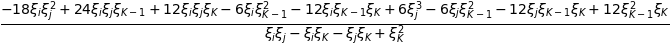

In [4]:
# define all our variables
x = symbols('x')
ki, kj = symbols('\\xi_i'), symbols('\\xi_j')
kl, kp = symbols('\\xi_{K}'), symbols('\\xi_{K-1}')

# define integral constructed from all our variables
dKp = (x - kp)**3/(kl - kp)
dKi = (x - ki)**3 / (kl - ki)
dKj = (x - kj)**3 / (kl - kj)
integral_part_1 = integrate(dKi.diff(x, 2)*dKj.diff(x, 2),
                            (x, kj, kp))
integral_part_2 = integrate((dKi - dKp).diff(x, 2)*(dKj - dKp).diff(x, 2),
                            (x, kp, kl))
total_integral = integral_part_1 + integral_part_2

# print the integral
simplify(total_integral)

## Smoothing Spline Implementation

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List
from numpy.linalg import inv
from scipy import optimize

In [6]:
class SmoothingSpline1D(BaseEstimator, TransformerMixin):
    """One dimensional smoothing spline.
    Parameters
    ----------
    dof :
        The target effective degrees of of freedom of a smoothing spline.
    Attributes
    ----------
    knots_:
        Unique values of X training data.
    smooth_:
        The smoothing parameter that results in the target degrees of freedom.
    coef_:
        The vector of fitted coefficients for linear regression."""
    def __init__(self, dof: float):
        self.dof = dof

    def fit(self, X: np.ndarray, y: np.array) -> 'SmoothingSpline1D':
        """Fit SmoothingSpline1D model according to the given training data
           and parameters.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        y = np.atleast_2d(y).T
        self.knots_ = np.unique(X)
        N = self.__expand_natural_cubic(X, self.knots_)
        O = self.__calc_integral_matrix(self.knots_)
        self.smooth_ = optimize.newton(
            lambda s: self.__calc_dof(N, O, s) - self.dof,
            0.00005, maxiter=100)
        self.coef_ = inv(N.T @ N + self.smooth_ * O) @ N.T @ y
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Natural cubic spline basis expansion.
        Parameters
        ----------
        X :
            Input data.
        Returns
        -------
        X_new :
            Transformed data.
        """
        return self.__expand_natural_cubic(X, self.knots_)

    def predict(self, X: np.ndarray) -> np.array:
        return self.transform(X) @ self.coef_

    @staticmethod
    def __calc_dof(N, O, smoothing):
        return np.trace(N @ inv(N.T @ N + smoothing * O) @ N.T)

    @staticmethod
    def __dk(X: np.ndarray, knot: float, knot_last: float) -> np.ndarray:
        return (X - knot).clip(0) ** 3 / (knot_last - knot)

    @staticmethod
    def __expand_natural_cubic(X: np.ndarray, knots: np.array) -> np.ndarray:
        basis_splines = [np.ones(shape=(X.size, 1)), X]
        dk_last = SmoothingSpline1D.__dk(X, knots[-2], knots[-1])
        for knot in knots[:-2]:
            dk = SmoothingSpline1D.__dk(X, knot, knots[-1])
            basis_splines.append(dk - dk_last)
        return np.hstack(basis_splines)

    @staticmethod
    def __calc_integral_matrix(knots: np.array) -> np.ndarray:
        O = np.zeros(shape=(knots.size, knots.size))
        for i in range(2, knots.size):
            for j in range(i, knots.size):
                O[i, j] = O[j, i] = SmoothingSpline1D.__calc_integral(
                    knots[i-2], knots[j-2], knots[-2], knots[-1])
        return O

    @staticmethod
    def __calc_integral(i, j, p, l):
        return (-18*i*j*j + 12*i*j*l + 24*i*j*p - 12*i*l*p - 6*i*p*p +
                6*j*j*j - 12*j*l*p - 6*j*p*p + 12*l*p*p) / \
               (i*j - i*l - j*l + l*l)

In [7]:
# split the data into male and female datasets
X_male, y_male = df_male[['age']].values, df_male.spnbmd.values
X_female, y_female = df_female[['age']].values, df_female.spnbmd.values
# fit 1D smoothing spline to the data
sp_male = SmoothingSpline1D(dof=12).fit(X_male, y_male)
sp_female = SmoothingSpline1D(dof=12).fit(X_female, y_female)
# calculate values for plotting
x_plot_male = np.linspace(sp_male.knots_[0], sp_male.knots_[-1], 100)
y_plot_male = sp_male.predict(np.atleast_2d(x_plot_male).T)
x_plot_female = np.linspace(sp_female.knots_[0], sp_female.knots_[-1], 100)
y_plot_female = sp_female.predict(np.atleast_2d(x_plot_female).T)

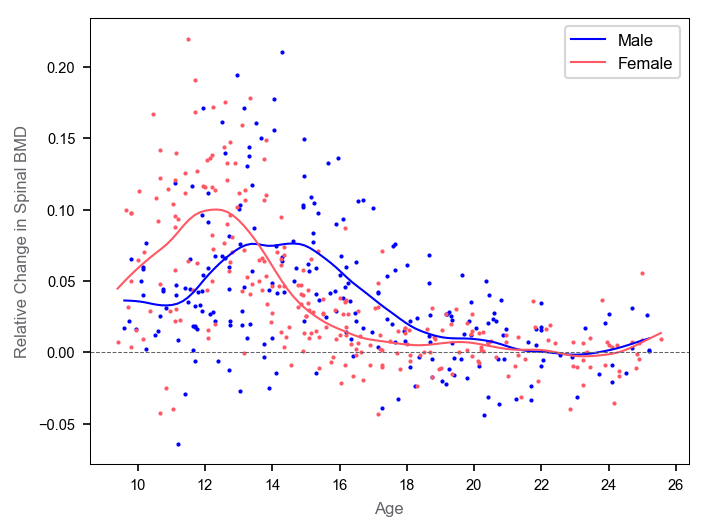

In [8]:
# PAGE 152. FIGURE 5.6. The response is the relative change in bone mineral
#           density measured at the spine in adolescents, as a function of age.
#           A separate smoothing spline was fit to the males and females, with
#           λ ≈ 0.00022. This choice corresponds to about 12 degrees of
#           freedom. The data are color coded by gender, and two separate
#           curves were fit. This simple summary reinforces the evidence in the
#           data that the growth spurt for females precedes that for males by
#           about two years.
fig, ax = plt.subplots(figsize=(5.15, 3.94), dpi=150)
ax.plot(x_plot_male, y_plot_male, color=BLUE, linewidth=1, label='Male')
ax.plot(x_plot_female, y_plot_female, color=RED, linewidth=1, label='Female')
ax.scatter(X_male, y_male, color=BLUE, s=1)
ax.scatter(X_female, y_female, color=RED, s=1)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)
ax.axhline(y=0, c=GRAY4, linewidth=0.5, linestyle='--')
ax.set_xlabel('Age', color=GRAY4, fontsize=8)
ax.set_ylabel('Relative Change in Spinal BMD', color=GRAY4, fontsize=8)
_ = ax.legend(loc='upper right', prop={'size': 8})